In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import pylab as pp
import numpy as np
import scipy as sp

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.decomposition import PCA
# Import curve fitting package from scipy
from scipy.optimize import curve_fit


from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# loading the formated datasets

In [3]:
trainData = []
testData = []
RUL = []

for i in range(1,5):
    trainData.append( pd.read_csv(('train_FD00%d_smooth.csv' % i),
                                  sep=' ',
                                  index_col=(0,1),
                                  header = 0,
                                  decimal='.',
                                  engine='python'))
    testData.append(pd.read_table(('test_FD00%d_smooth.csv' % i),
                                  sep=' ',
                                  index_col=(0,1),
                                  header = 0,
                                  decimal='.',
                                  engine='python'))
    RUL.append(pd.read_table(('RUL_FD00%d.txt' % i),
                             sep=' ',
                             index_col=False,
                             names=['RULtime'],
                             header = None,
                             engine='python'))

#  metadata from file readme.txt
FD001 = {"Data Set Name": "FD001",
         "idx" : 0,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD002 = {"Data Set Name": "FD002",
         "idx" : 1,
         "Train trjectories:": 260,
         "Test trajectories:" : 259,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD003 = {"Data Set Name": "FD003",
         "idx" : 2,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

FD004 = {"Data Set Name": "FD004",
         "idx" : 3,
         "Train trjectories:": 249,
         "Test trajectories:" : 248,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

metadata = [FD001,FD002,FD003,FD004]


* data are loaded in the Pandas DataFrames
* each DF contains data from the whole file
* DF has multiindex consisting of unit and time

* The datasets are organized in two separate lists, one for training datasets, second for the test datasets.
* Unlike the original datasets, each formated dataset contain a header row with names of columns in the first row.
* The time is in cycles, counting from the last cycle recorded cycle in each trajectory. I.e. in the case of train data, the time represents the remaining useful lifetime, RUL.

## a quick peak at the smoothed and formated data FD003

In [4]:
# dataset index
meta = FD003

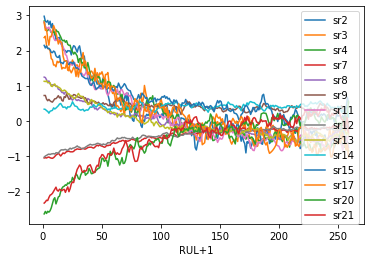

In [5]:

trainData[meta['idx']].loc[1,'sr2':].plot();

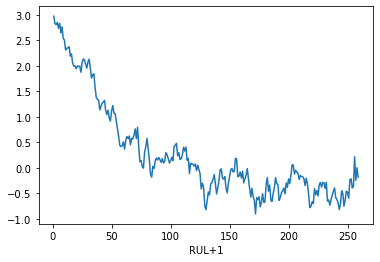

In [6]:
trainData[meta['idx']].loc[1,'sr2'].plot()

The data show typical wear curve, elbow point from where the fault develops exponentially

# data reduction with PCA

In [7]:

train_data = trainData[meta['idx']].loc[:,'sr2':] # include only the sensor readings in the PCA, not the op's

## applying the PCA on the sensor readings in whole training dataset
# Make an instance of the Model
pca = PCA(.97)
pca.fit(train_data)
print(pca.n_components_)

4


Four PCs are needed to explain more than 97% of the variance. 

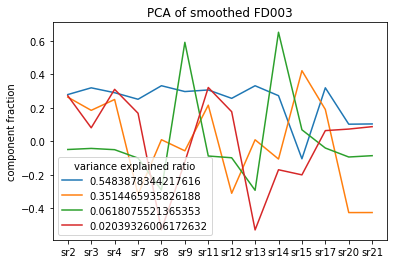

In [8]:
pp.plot(pca.components_.T,)
pp.legend(pca.explained_variance_ratio_,title='variance explained ratio');
pp.xticks(np.arange(0, len(train_data.columns), 1), train_data.columns)
pp.ylabel('component fraction');
pp.title('PCA of smoothed ' + meta['Data Set Name']) ;

The PCA characterize the two modes of fault:

* there are 4 significant PCs: listed in order of decreasing explanied variance ratio: PC1 (54%), PC2 (35 %), PC3 (6 %) and PC4 (2%)

* the green-curve PCA with about 6% expl. var. resemble the fault mode observed in the data set FD001
* unsure about the requirement for the 2% EV PC. we'll see from the transformed trajectories

In [9]:
# Apply PCA transform to both the training set and the test set.
train_data = pca.transform(train_data)
test_data = testData[meta['idx']].loc[:,'sr2':]
test_data = pca.transform(test_data)

In [10]:
print(test_data. shape, train_data.shape)

(16596, 4) (24720, 4)


### Couple the op data with the transformed sensor readings - the pcs:

In [11]:
train_dataPD = pd.DataFrame(index=trainData[meta['idx']].index,columns=['op1','op2','pc1','pc2','pc3','pc4'])
train_dataPD.loc[:,'op1':'op2'] = trainData[meta['idx']].loc[:,'op1':'op2']
train_dataPD.loc[:,'pc1':'pc4'] = train_data

test_dataPD = pd.DataFrame(index=testData[meta['idx']].index,columns=['op1','op2','pc1','pc2','pc3','pc4'])
test_dataPD.loc[:,'op1':'op2'] = testData[meta['idx']].loc[:,'op1':'op2']
test_dataPD.loc[:,'pc1':'pc4'] = test_data


In [12]:
train_dataPD.head()

op1     op2      pc1      pc2        pc3       pc4
unit RUL+1                                                       
1    1      0.0043 -0.0001  3.99856  6.66992  0.0018435  0.370615
     2     -0.0005  0.0001  3.82402  6.43589  0.0220312  0.263453
     3     -0.0032 -0.0002  3.65266  6.39414 -0.0288095  0.233016
     4      0.0019  0.0001  3.50451  6.26923 -0.0306323  0.317029
     5       0.005 -0.0004  3.46212  6.19971 -0.0543446  0.291636

In [13]:
test_dataPD.head()

op1     op2      pc1      pc2        pc3       pc4
unit time                                                       
1    1     0.0021  0.0002  3.05901 -2.57413 -0.0753175  0.264034
     2     0.0038 -0.0005  2.93333 -2.51669 -0.0487394  0.266349
     3    -0.0002  0.0004  2.89334  -2.4549  -0.103544  0.333778
     4     0.0018       0  2.84947 -2.39237  -0.122808  0.373784
     5      0.003  0.0001   2.6896 -2.28033 -0.0717677  0.381208

# look at the operational parameters

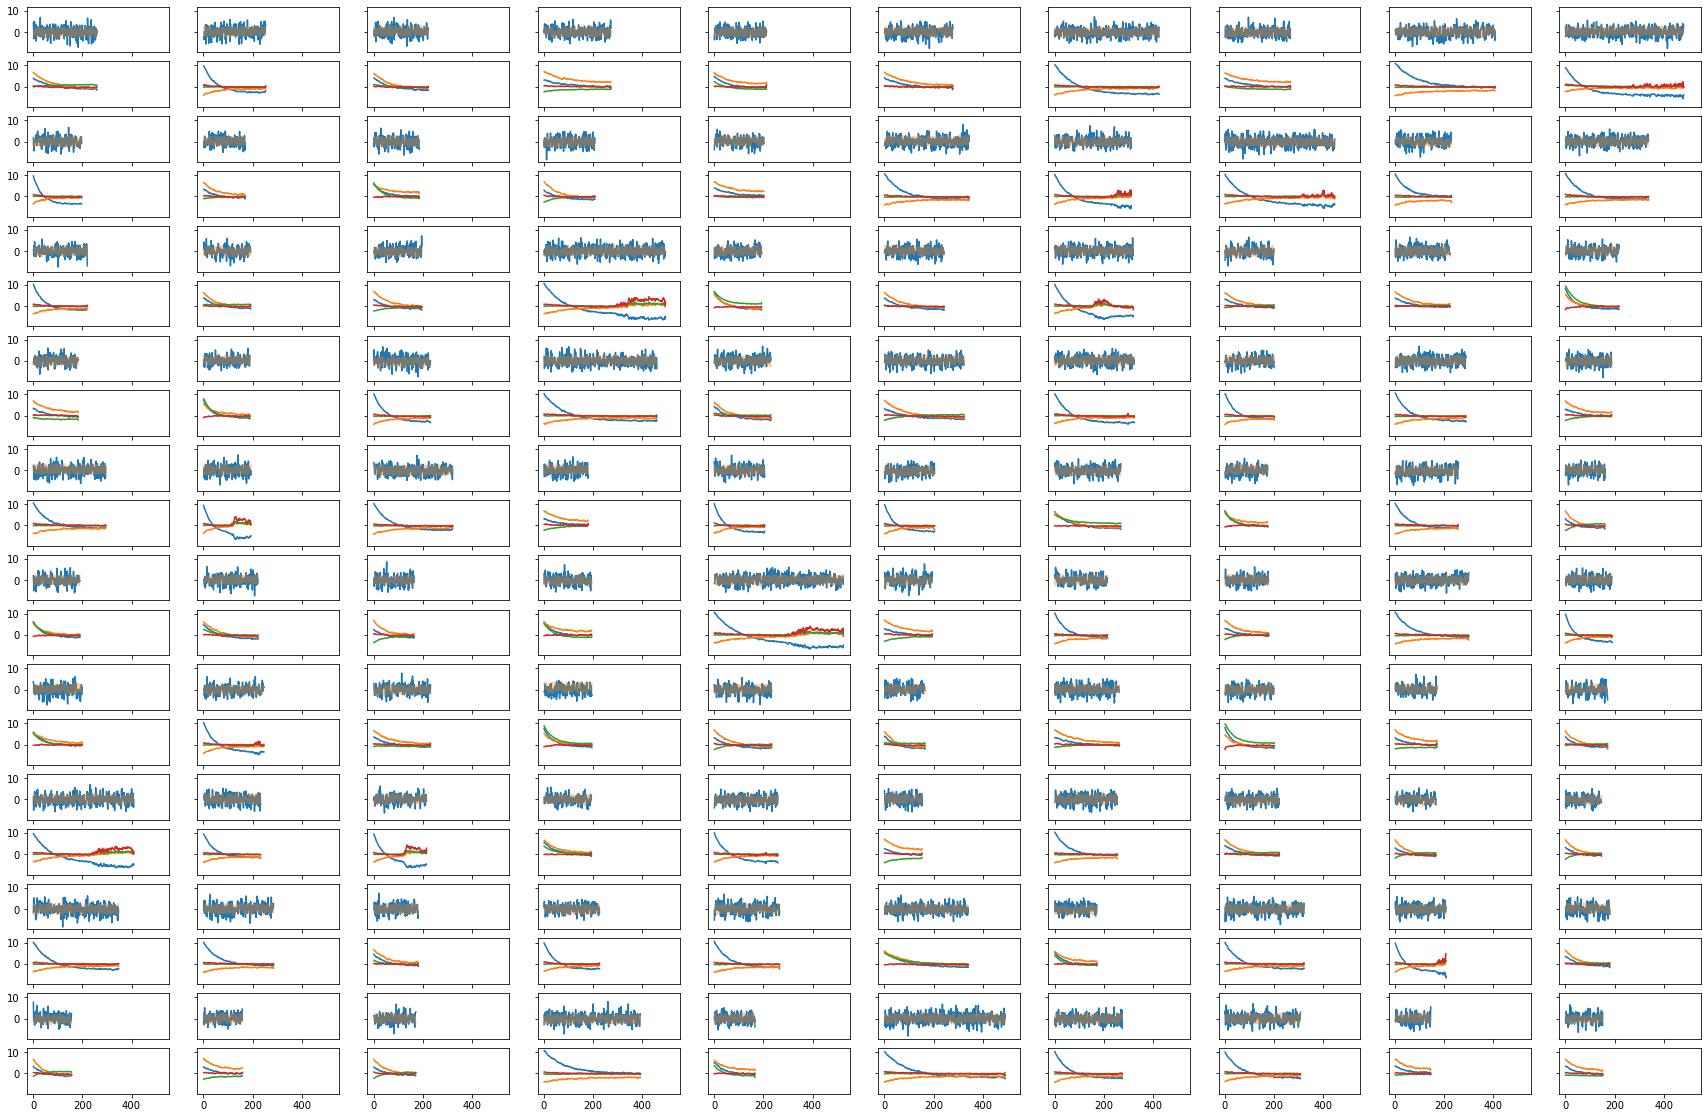

In [14]:
nrows=10
ncols=10
fig, ax = pp.subplots(figsize=(30,20),nrows=2*nrows, ncols=ncols, sharex=True, sharey=True,)
#ax=ax.flatten()
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx*2
        col=traj_idx
        ax[row,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'op1']*1000)
        ax[row,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'op2']*5000,alpha=0.4)
        # PC of the sensor readings on the every odd row
        ax[row+1,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'pc1':'pc4'])
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc2'],alpha=0.8)
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc3'],alpha=0.6)
        

Observations:
* The operation conditions for all the trajectories are more-or less equal in all trajectories.
 
* some trajectories contain eviden "induction period", that is apparent from spikes (relatively high RMS noise) in PC3 ansd PC4. It indicates that the period can be oconsidered as that of a normal operation, and thus can be excluded form fault development.
* differently from the case of FD001 data set, the first PC does not always terminate at around 10, but sometimes at around 3. These are evidently the two fault modes given in the data. It is not clear, whether the combination of the two modes is possible. As that would constitute effectivelly an infinite number of combinaitons, we will not consider this in the model.
    * the first mode is characterized by first PC that terminates at value of about 10. In those cases, this PC dominates throughout the trajectory.
    * the second mode ends with second PC dominating the signals, and in those cases, this PC dominates from the onset of the exponential kinetics
* in the later case the second PC dominates, but shows the same kinetics as PC1 - exponential.

# machine learning pipeline:

* remove the initial part of each trajectory, where there are high values of PC3 and PC4
* classify the trajectories in two groups dependent on the failure mode - unsupervised clustering baseed on PC1 and PC2 (K-menans with dymanic time warping method)
    * fit model utilizing exponential, with induction period

# clustering based on PC3 - induction period

Text(0.5, 1.0, 'trajectrory: 18')

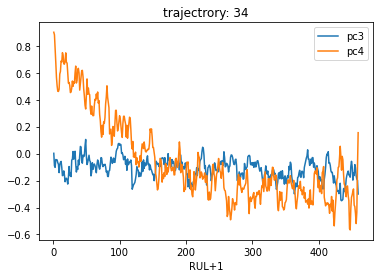

<Figure size 432x288 with 0 Axes>

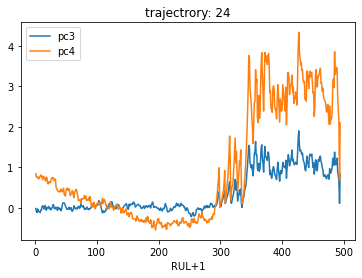

<Figure size 432x288 with 0 Axes>

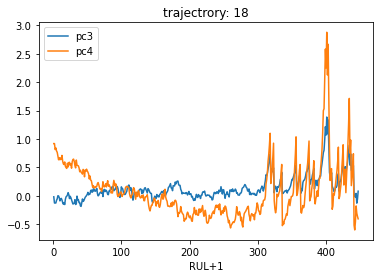

In [15]:
trajectory = 34
train_dataPD.loc[trajectory,'pc3':].plot();
pp.title('trajectrory: %d' % trajectory)

fig=pp.figure()
trajectory = 24
train_dataPD.loc[trajectory,'pc3':].plot();
pp.title('trajectrory: %d' % trajectory)

fig=pp.figure()
trajectory = 18
train_dataPD.loc[trajectory,'pc3':].plot();
pp.title('trajectrory: %d' % trajectory)

The PC4 is probably a good indicator of the system wear - its value drifts after a plateau that is slightly  below 0 to the value about 1.0, when the systems breaks down. Will try to further smoothen it and apply thresholds to dissect the trajectory into "burn-in", "normal operation", "failing"  periods. Sometimes, the burn-in period is missing.

C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


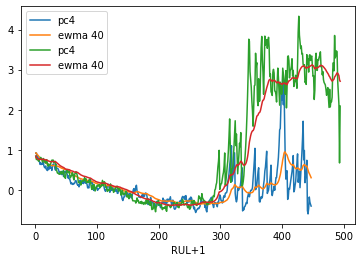

In [16]:
trajectory = 18

ax=pp.axes()
sensorTrace = train_dataPD.loc[trajectory,'pc4']
sensorTrace.plot(ax=ax)
ewma_span = 40
SM=sensorTrace.ewm(span=ewma_span,ignore_na=True).mean()
SM.plot(ax=ax,label=('ewma ' + str(ewma_span)))
SMmask=SM[SM>1]
pp.plot()

ax.legend()
trajectory = 24

ax=pp.axes()
sensorTrace = train_dataPD.loc[trajectory,'pc4']
sensorTrace.plot(ax=ax)
ewma_span = 40
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=('ewma ' + str(ewma_span)))
ax.legend()

In [17]:
# what about to use moving RMS to dissect the data?

def window_rmsdev(intervalS, halfwindow):
    """ performs the moving-window smoothing of a signal using RMS """
    interval = intervalS.values
    rms_signalS = pd.Series(index=intervalS.index, name=intervalS.name,dtype=np.float64)
    n = len(interval)
    rms_signal = np.zeros(n)
    for i in range(n):
        small_index = max(0, i - halfwindow)  # intended to avoid boundary effect
        big_index = min(n, i +  halfwindow)    # intended to avoid boundary effect
        window_samples = interval[small_index:big_index]
        x=np.mean(window_samples)
        # here is the RMS of the window, being attributed to rms_signal 'i'th sample:
        rms_signal[i] = np.sqrt(sum([(s-x)**2 for s in window_samples])/len(window_samples))
    rms_signalS.iloc[:] = rms_signal
    return rms_signalS


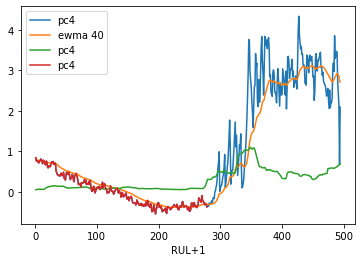

In [18]:
trajectory = 24

ax=pp.axes()
sensorTrace = train_dataPD.loc[trajectory,'pc4']
sensorTrace.plot(ax=ax)
ewma_span = 40
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=('ewma ' + str(ewma_span)))

###### parameters for RMSdev the mask #######
window_size = 20
rmsdev_thrshld = 0.3
movRMS  =window_rmsdev(sensorTrace,window_size)
movRMS.plot()
#pp.plot(sensorTrace.index,movRMS,'ro')
ax.grid(b=True,which='both')
sensorTrace[movRMS<rmsdev_thrshld].plot()

ax.legend();



I will use only red-colored part of the trajectory in further analysis.

# trajectory classification by the PC1 and PC2 behavior

In [19]:
# formating the data
train_dataLST = []
test_dataLST = []

# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20

# construct the list of trajectories for creation of TimeSeries dataset
# apply mask based on PC4   
for traject in range(1,meta["Train trjectories:"]+1):
    # create mask
    movRMS  =window_rmsdev(train_dataPD.loc[traject,'pc4'],window_size)
    maskIdxs =   movRMS[movRMS<rmsdev_thrshld].index  
    if len(maskIdxs)<minMaskLen:
        maskIdxs = movRMS.index
    traj = train_dataPD.loc[traject,'pc1':'pc2'].loc[maskIdxs,:].values.flatten()
    train_dataLST.append(traj)
    
for traject in range(1,meta['Test trajectories:']+1):
    movRMS  =window_rmsdev(test_dataPD.loc[traject,'pc4'],window_size)
    maskIdxs =   movRMS[movRMS<rmsdev_thrshld].index    
    if len(maskIdxs)<minMaskLen: # if there are no remaining datapoints, use full dataset.
        maskIdxs = movRMS.index
    traj = test_dataPD.loc[traject,'pc1':'pc2'].loc[maskIdxs,:].values.flatten()
    test_dataLST.append(traj)

train_dataTS = to_time_series_dataset(train_dataLST)
test_dataTS = to_time_series_dataset(test_dataLST)
a=[]
a.extend(train_dataLST)
a.extend(test_dataLST)
full_dataTS = to_time_series_dataset(a)

In [20]:
model = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=50,n_jobs=-1)
model.fit(train_dataTS)

TimeSeriesKMeans(metric='dtw', n_clusters=2, n_jobs=-1)

In [21]:
model.labels_

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1], dtype=int64)

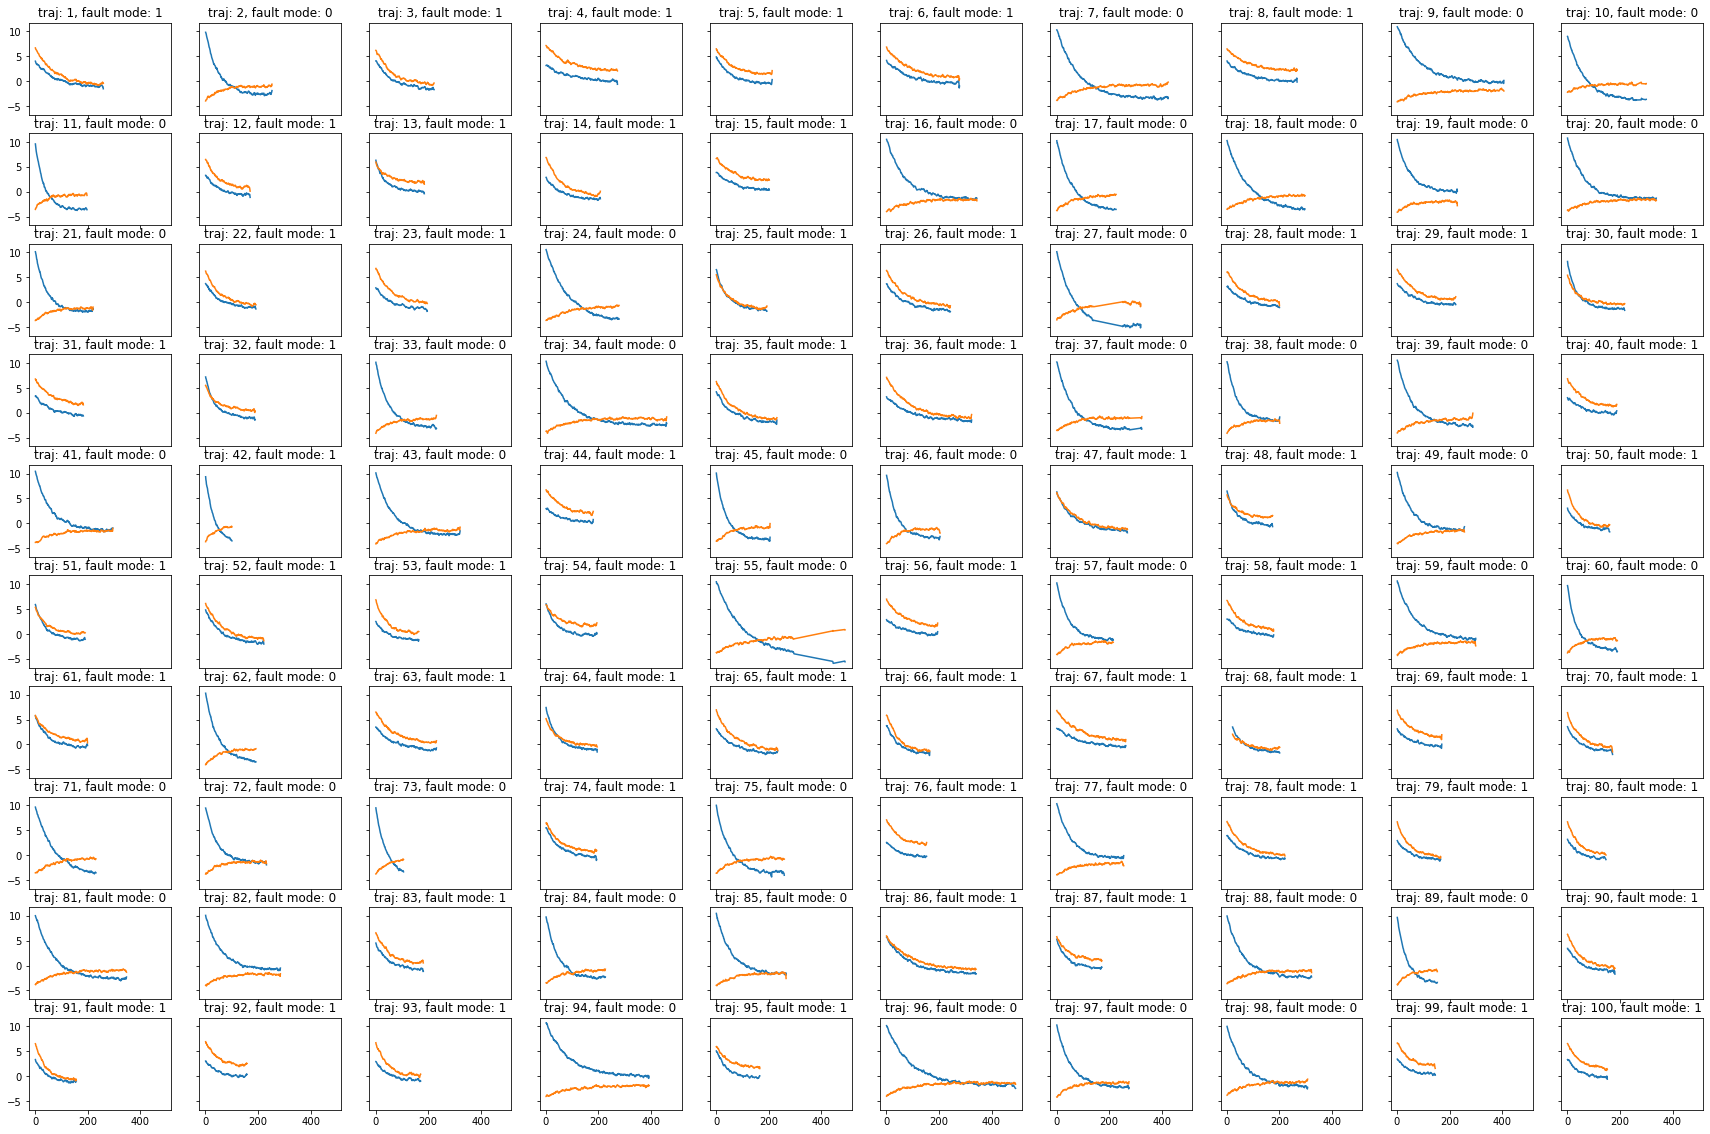

In [22]:
nrows=10
ncols=10
fig, ax = pp.subplots(figsize=(30,20),nrows=nrows, ncols=ncols, sharex=True, sharey=True,)
#ax=ax.flatten()
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx
        col=traj_idx
        unit_idx = ncols*traj_jdx+traj_idx+1
        # PC of the sensor readings on the every odd row
        movRMS  =window_rmsdev(train_dataPD.loc[unit_idx,'pc4'],window_size)
        maskIdxs =   movRMS[movRMS<rmsdev_thrshld].index
        ax[row,col].plot(train_dataPD.loc[unit_idx,'pc1':'pc2'].loc[maskIdxs,:])
        ax[row,col].set_title('traj: %d, fault mode: %d' % ( unit_idx, model.labels_[unit_idx-1]))
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc2'],alpha=0.8)
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc3'],alpha=0.6)
      

The classification result is satisfactory:
fault modes are:
* 0: Fan degradation
* 1: HPC degradation (like in dataset FD003)


In [23]:
meta['Fault mode labels train'] = pd.Series(index=np.arange(1,meta['Train trjectories:']+1),
                                             data=model.labels_, name='Fault mode labels train')

## the test dataset classification

For this task, we will use the composite dataset, train and test.

In [24]:
model = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=10,n_jobs=-1)
model.fit(full_dataTS)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=2, n_jobs=-1)

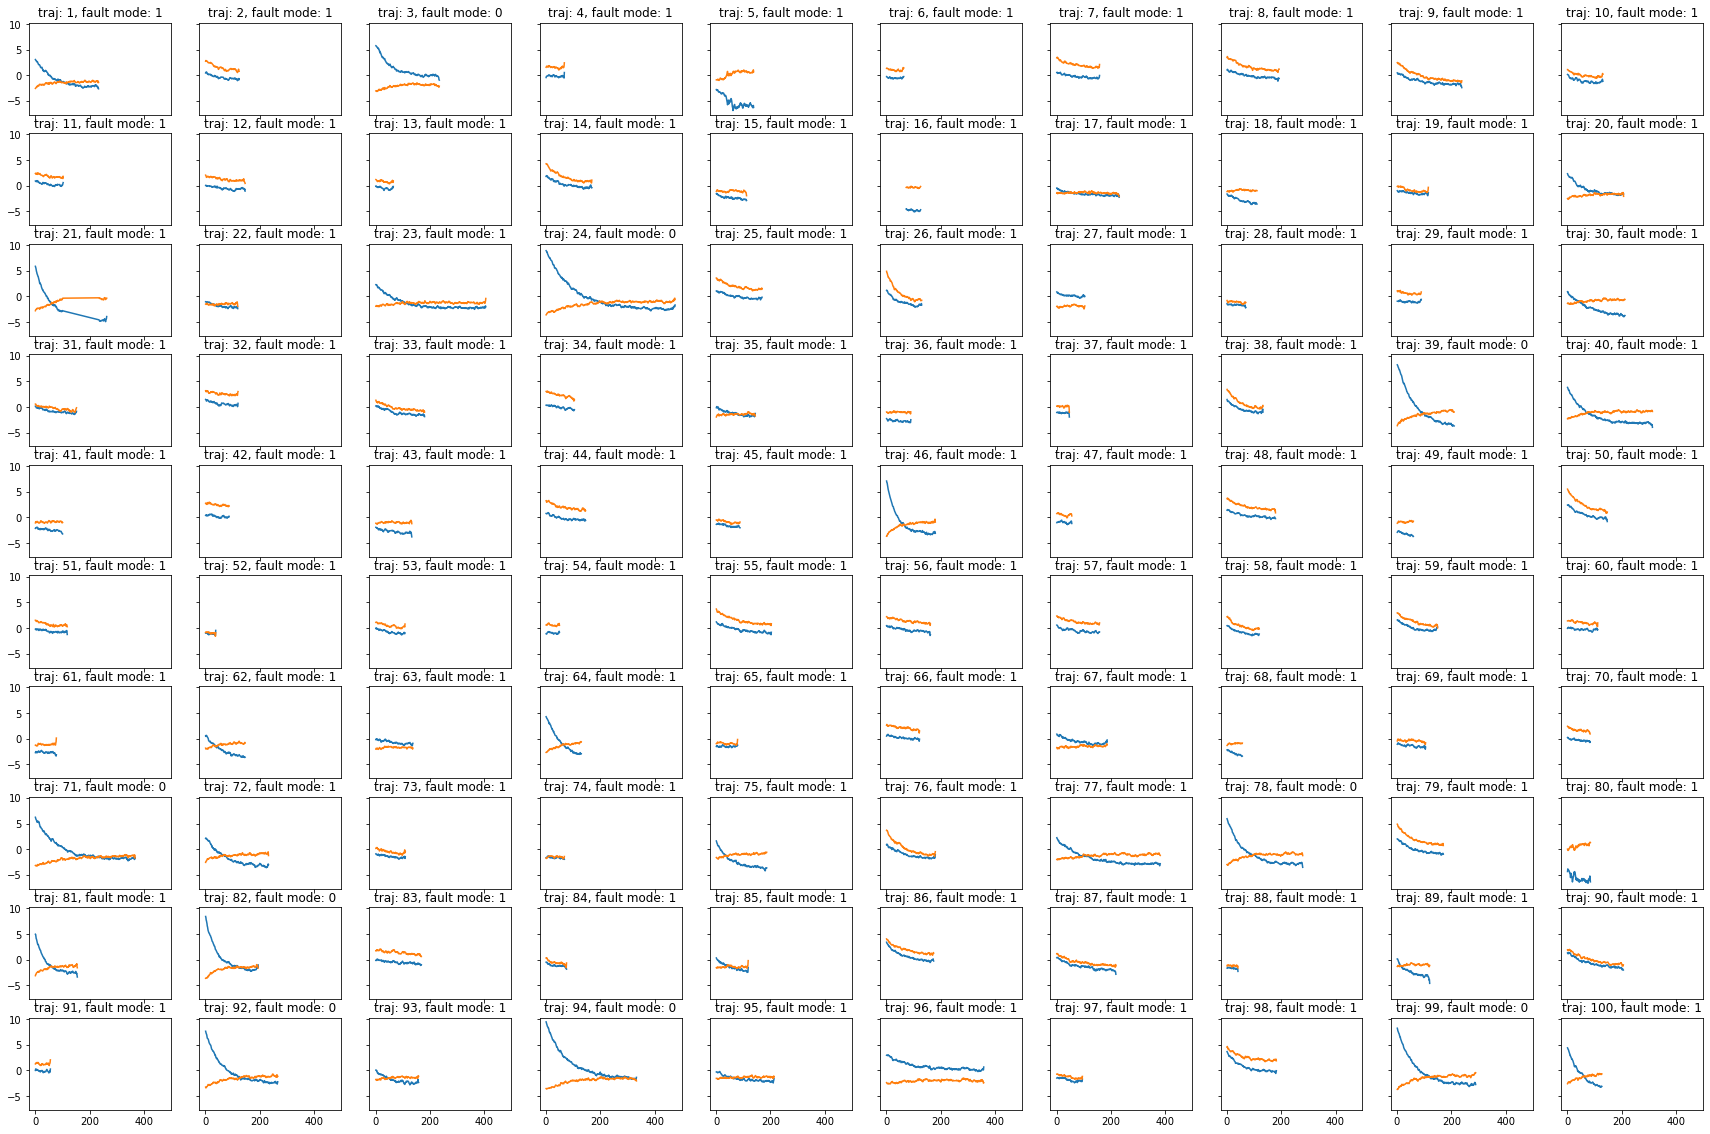

In [25]:
nrows=10
ncols=10
fig, ax = pp.subplots(figsize=(30,20),nrows=nrows, ncols=ncols, sharex=True, sharey=True,)
#ax=ax.flatten()
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx
        col=traj_idx
        unit_idx = ncols*traj_jdx+traj_idx+1
        # PC of the sensor readings on the every odd row
        movRMS  =window_rmsdev(test_dataPD.loc[unit_idx,'pc4'],window_size)
        maskIdxs =   movRMS[movRMS<rmsdev_thrshld].index
        if len(maskIdxs)<minMaskLen:
            maskIdxs = movRMS.index
        ax[row,col].plot(test_dataPD.loc[unit_idx,'pc1':'pc2'].loc[maskIdxs,:])
        ax[row,col].set_title('traj: %d, fault mode: %d' % ( unit_idx, model.labels_[unit_idx+100-1]))
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc2'],alpha=0.8)
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc3'],alpha=0.6)
      

The test dataset is classified erroneously. Often, when there is crossing of PC1 and PC2, it shows wrong class 1, when there should be class 0.

Moreover the TS-K-Means classification is resource intensive.

The fault modes were numberred oppositely:
* 1: Fan degradation
* 0: HPC degradation (like in dataset FD001)

This classification  will not be used like this further. Possible improvements are:
* process the input data by linear fit, and identify the classes from the fit parameters, namely the slope of the PC2 evolution.


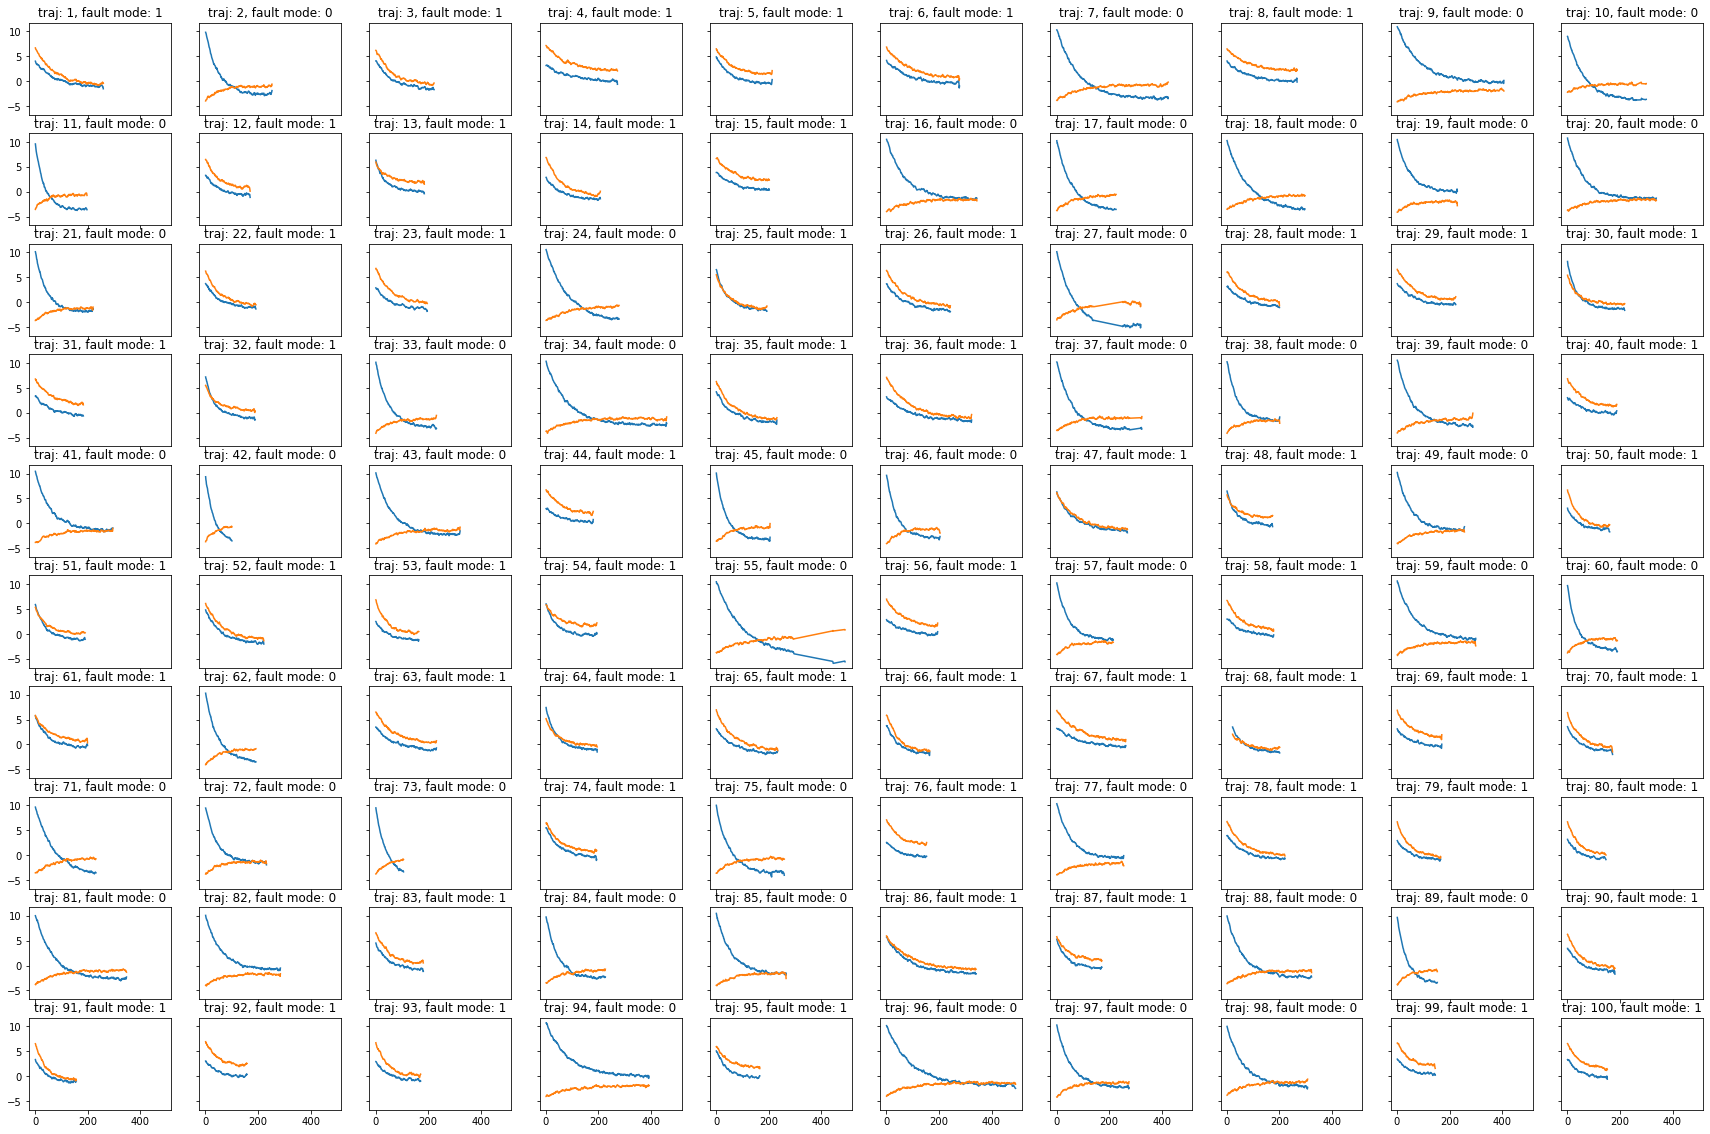

In [26]:
nrows=10
ncols=10
fig, ax = pp.subplots(figsize=(30,20),nrows=nrows, ncols=ncols, sharex=True, sharey=True,)
#ax=ax.flatten()
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx
        col=traj_idx
        unit_idx = ncols*traj_jdx+traj_idx+1
        # PC of the sensor readings on the every odd row
        movRMS  =window_rmsdev(train_dataPD.loc[unit_idx,'pc4'],window_size)
        maskIdxs =   movRMS[movRMS<rmsdev_thrshld].index
        ax[row,col].plot(train_dataPD.loc[unit_idx,'pc1':'pc2'].loc[maskIdxs,:])
        ax[row,col].set_title('traj: %d, fault mode: %d' % ( unit_idx, model.labels_[unit_idx-1]))
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc2'],alpha=0.8)
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc3'],alpha=0.6)
      

The train dataset is classified still well. 

## classification based on exponential decay model fit:
* HPC degradation fault mode has PC1 moving upwards, but PC2 is moving downwards
* Fan degradation mode has both trends moving downwards

Therefore the signs of an amplitudes of the exponential fit of PC1 and PC2 will be a good classification parameter.

## Try predictive models

## exponential model exploring the train data set

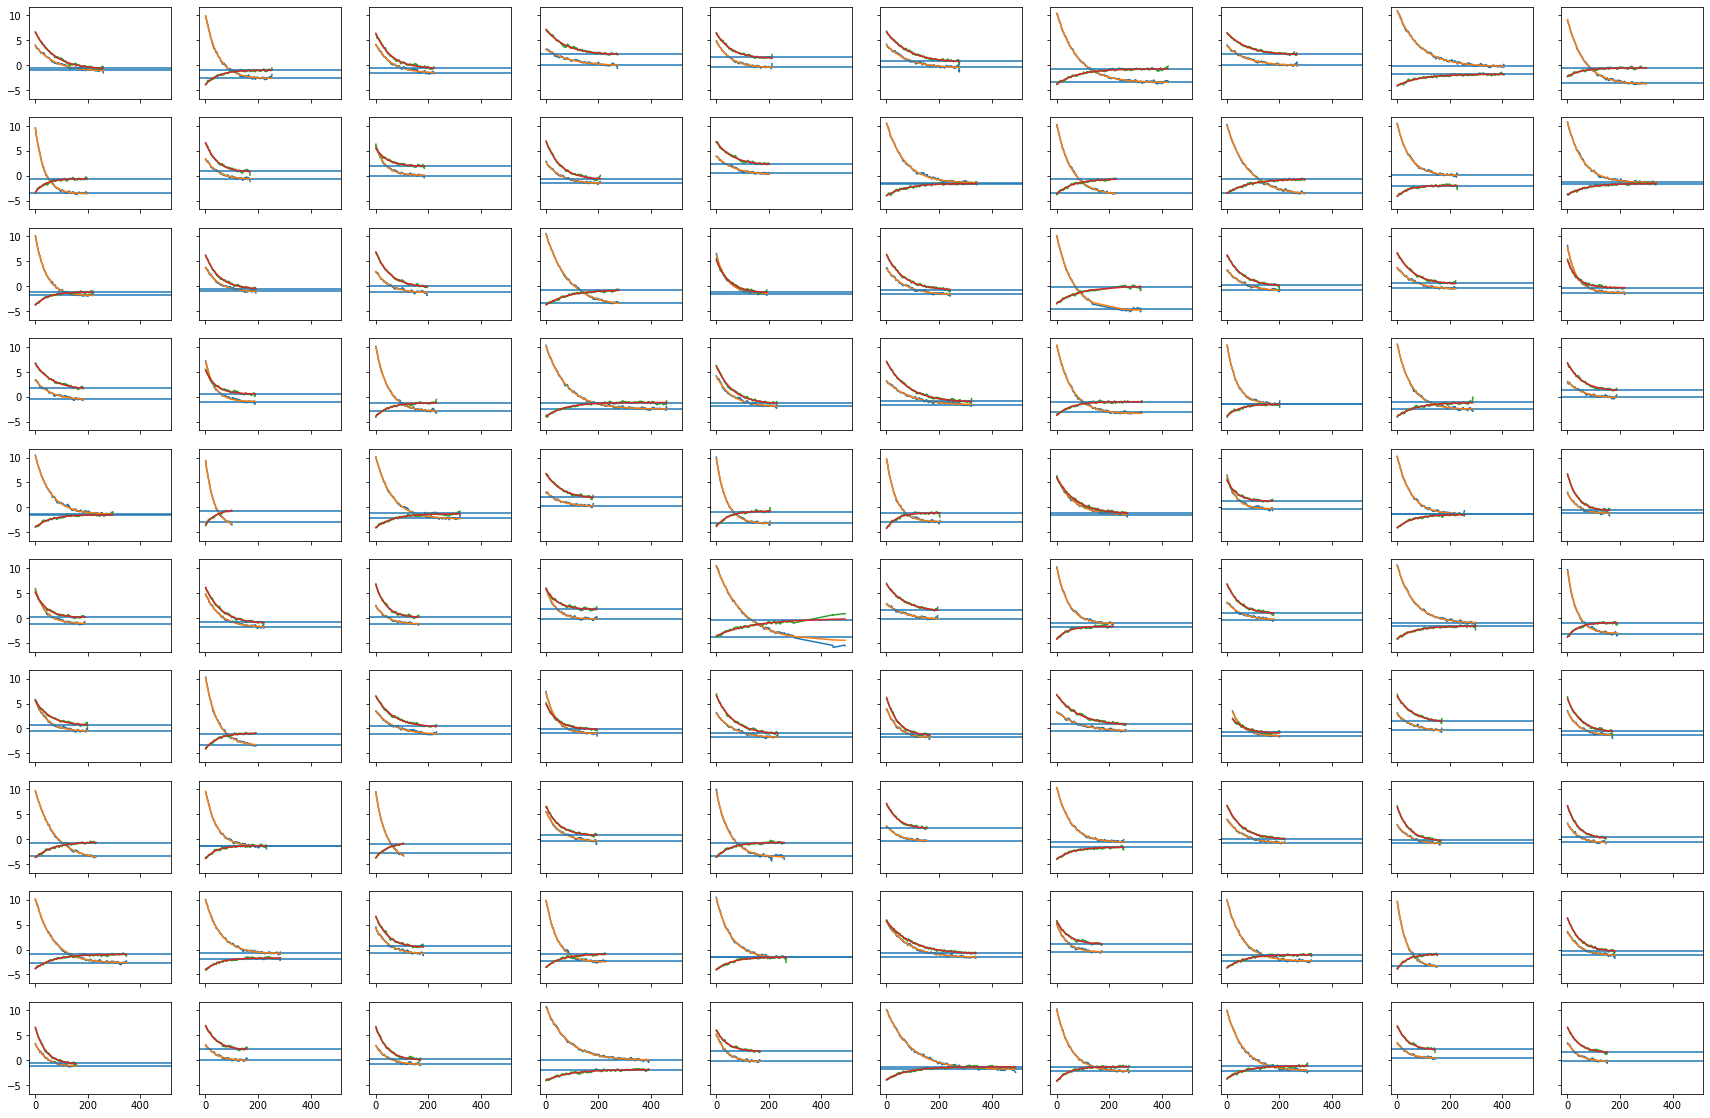

In [27]:


# Function to calculate the exponential with constants a and b
def exponential(x, A, k, y):
    return (A*np.exp(-k*(x))  + y)

# data
dataPD=train_dataPD
maskSignal = 'pc4'
progSig = ['pc1','pc2'] # prognostic signals    


# data structure for the fit result
pcolumns = ['A1', 'k1', 'y1', 'A1std', 'k1std', 'y1std',
           'A2', 'k2', 'y2', 'A2std', 'k2std', 'y2std'] # parameter columns

fit_expDF = pd.DataFrame(index=np.arange(1,meta["Train trjectories:"]),
                             columns=pcolumns)
fit_expDF.rename_axis(['unit',], inplace=True,axis=0)

# initial fit parameters for the fitting function
base_span = 30

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20


nrows=10
ncols=10
plotRows=1
fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx*plotRows
        col=traj_idx
        data_idx = ncols*traj_jdx+traj_idx+1
        #ax[row,col].plot(dataPD.loc[data_idx,'op1']*1000)
        #ax[row,col].plot(dataPD.loc[data_idx,'op2']*5000,alpha=0.4)
        #ax[row,col].axhline(y=0)
        # get mask
        movRMS  =window_rmsdev(dataPD.loc[data_idx,maskSignal],window_size)
        maskIdxs =   movRMS[movRMS<rmsdev_thrshld].index
        if len(maskIdxs)<minMaskLen:
            maskIdxs = movRMS.index
        
        pc_idx=0 # position index of the prognostic parameter in the progSig list
        pars_errsA= np.array([],dtype=np.float)
        
        for pc in progSig:
            trace=dataPD.loc[data_idx,pc].loc[maskIdxs]
            ax[row,col].plot(trace)
            
            base = trace.iloc[-base_span:].mean()
            p0 = [8-base, 0.02, -0.1]

            ax[row,col].axhline(y=base)

            X = trace.index.values
            y = trace.values.astype(np.float)

            # Fit the experimental data
            pars, cov = curve_fit(f=exponential, xdata=X, ydata=y, p0=p0, bounds=(-np.inf, np.inf))
            perr = np.sqrt(np.diag(cov)) # standard deviation errors on the parameters
            pars_errs = np.hstack([pars,perr])

            #print('score: ',reg.score(X, y), )
            yy = exponential(X, *pars)
            ax[row,col].plot(X,yy)
            pars_errsA=np.hstack([pars_errsA,pars_errs])
            pc_idx+=1
        fit_expDF.loc[data_idx,:]= pars_errsA
            


The exponential model fits the data well. I will try to use it for prediction.

In [28]:

meta['exp_train_fit'] = pd.DataFrame(index=fit_expDF.index,columns=fit_expDF.columns,
                                     data=fit_expDF.values,dtype=np.float)


In [29]:
meta['exp_train_fit'].describe()

,A1,k1,y1,A1std,k1std,y1std,A2,k2,y2,A2std,k2std,y2std
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,8.537583,0.019407,-1.620905,0.042411,0.000317,0.024735,2.203660,0.018502,-0.323144,0.041317,0.000471,0.025941
std,4.073651,0.005268,1.248923,0.010103,0.000207,0.008344,4.532572,0.004633,1.113968,0.010779,0.000228,0.010567
min,2.954903,0.009490,-4.857558,0.030244,0.000057,0.010788,-3.516703,0.006690,-1.964115,0.024440,0.000105,0.010024
25%,4.718488,0.015476,-2.346606,0.035583,0.000133,0.018270,-2.709720,0.014838,-1.147664,0.035762,0.000320,0.018560
50%,7.491665,0.018881,-1.373315,0.042044,0.000281,0.023528,4.600342,0.018111,-0.685163,0.039700,0.000419,0.025378
75%,12.600632,0.023632,-0.624672,0.046383,0.000450,0.030236,6.431094,0.022378,0.402015,0.045002,0.000572,0.030189
max,15.241967,0.030994,0.345092,0.112205,0.000882,0.052084,8.257441,0.026823,2.100021,0.113555,0.001457,0.077569


Observations: 
* The engine degradation rate constants k vary 1.5-fold. This is less than in the case of FD001 train dataset.
* y0 and A are not independent, they should be correlated to yield almost constant sum value
* estimation errors are pretty low

I will add the classification based on the sign of the amplitude A2 of the exponential fit of PC2

In [30]:
meta['exp_train_fit']['fault mode'] = ((np.sign(meta['exp_train_fit']['A2'].values)+1)//2).astype(np.int)

In [31]:
meta['exp_train_fit'].head()

,A1,k1,y1,A1std,k1std,y1std,A2,k2,y2,A2std,k2std,y2std,fault mode
unit,,,,,,,,,,,,,
1,5.232249,0.013603,-1.255447,0.033514,0.000243,0.025076,7.561841,0.013811,-0.861605,0.035849,0.000180,0.026174,1
2,12.912278,0.021301,-2.719803,0.053920,0.000181,0.020773,-2.930684,0.020025,-0.994026,0.037631,0.000544,0.015826,0
3,5.879181,0.016942,-1.641311,0.043353,0.000331,0.029110,7.218199,0.017355,-0.707713,0.046652,0.000291,0.030108,1
4,3.374731,0.010414,-0.206666,0.036294,0.000355,0.037051,5.181968,0.012888,2.022290,0.037143,0.000259,0.028027,1
5,5.482483,0.019090,-0.538446,0.035100,0.000304,0.020721,5.228691,0.017515,1.303698,0.036324,0.000324,0.024705,1


### signatures of exponential parameters for individual fault modes:

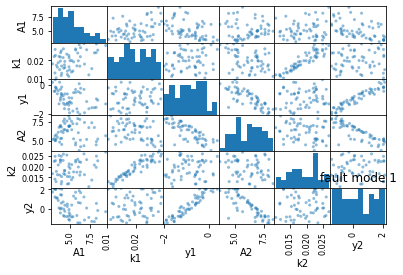

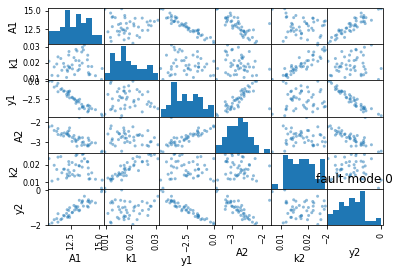

In [32]:
# store the fit results and plot the correlation graphs
meta['exp_train_fit_stats'] = []
for fm in meta['exp_train_fit']['fault mode'].unique():
    # select the trajectories of the given fault mode 'fm'
    singleMode_trajs = meta['exp_train_fit'][meta['exp_train_fit']['fault mode']==fm]
    meta['exp_train_fit_stats'].append(singleMode_trajs.describe().T)
    pd.plotting.scatter_matrix(singleMode_trajs[['A1','k1','y1','A2','k2','y2']],alpha=0.5);
    pp.title('fault mode %d' % fm )


Correlation between exponential parameter pairs are different in each failure mode:
* in failure mode 0 (HPC degradation) we observe that A1 and y1 are correlated. This yields rather constant value of PC1 at RUL=1:
* A2 and y2 in are somewhat correlated in the case of fault mode 1 (fan degradation)
* rate constants k1 and k2 are almost perfectly correlated in both fault modes.


In [33]:
fm = 0 # fault mode
s = meta['exp_train_fit'][meta['exp_train_fit']['fault mode']==fm]
(s['A1']+s['y1']).describe()

count    44.000000
mean     10.310958
std       0.361416
min       9.343021
25%      10.098344
50%      10.355788
75%      10.549406
max      11.028694
dtype: float64

Target value of the PC1 in the fault mode 0 is here 10.31 +- 0.36 : pretty narrowly distributed

In [34]:
(s[['k1','k2']]).describe()

,k1,k2
count,44.000000,44.000000
mean,0.018941,0.017648
std,0.005531,0.004869
min,0.009490,0.006690
25%,0.015160,0.013819
50%,0.017749,0.017370
75%,0.022689,0.021667
max,0.030994,0.026272


We should restrict the k1 value between min and max for fault mode 0

## in the case of fault mode 1

In [35]:
fm = 1 # fault mode
s = meta['exp_train_fit'][meta['exp_train_fit']['fault mode']==fm]
(s['A2']+s['y2']).describe()

count    56.000000
mean      6.401790
std       0.684677
min       3.437668
25%       6.118693
50%       6.626593
75%       6.833961
max       7.269544
dtype: float64

In [36]:
(s[['k1','k2']]).describe()

,k1,k2
count,56.000000,56.000000
mean,0.019772,0.019173
std,0.005072,0.004365
min,0.010414,0.010511
25%,0.015950,0.015999
50%,0.019603,0.019412
75%,0.023966,0.022833
max,0.029005,0.026823


We should restrict the k1 value between min and max for fault mode 1 too. Fitting only one value of k is probably sufficient.

# classify the test data set
based on the PC4

In [37]:
# Function to calculate the exponential with constants a and b
def linear(x, k, y):
    return (k*(x)  + y)
def exponential(x, A, k, y):
    return (A*np.exp(-k*(x))  + y)

class model:
    def __init__(self,dataPD, progSig,maskSignal,ufunc,p0,bounds,base_span,pcolumns, 
               window_size=20,rmsdev_thrshld=0.3,minMaskLen = 20):
        self.dataPD = dataPD
        self.progSig = progSig
        self.maskSignal=maskSignal
        self.ufunc = ufunc
        self.p0 = p0
        self.bounds = bounds
        self.base_span = base_span
        self.fit_expDF = pd.DataFrame(index=dataPD.index.get_level_values(level=0).unique(),
                             columns=pcolumns,dtype=np.float)
        self.window_size = window_size
        self.minMaskLen = minMaskLen
        self.rmsdev_thrshld = rmsdev_thrshld
        return
    def window_rmsdev(self,intervalS, halfwindow):
        """ performs the moving-window smoothing of a signal using RMS """
        interval = intervalS.values
        rms_signalS = pd.Series(index=intervalS.index, name=intervalS.name,dtype=np.float64)
        n = len(interval)
        rms_signal = np.zeros(n)
        for i in range(n):
            small_index = max(0, i - halfwindow)  # intended to avoid boundary effect
            big_index = min(n, i +  halfwindow)    # intended to avoid boundary effect
            window_samples = interval[small_index:big_index]
            x=np.mean(window_samples)
            # here is the RMS of the window, being attributed to rms_signal 'i'th sample:
            rms_signal[i] = np.sqrt(sum([(s-x)**2 for s in window_samples])/len(window_samples))
        rms_signalS.iloc[:] = rms_signal
        return rms_signalS

    def fit(self):
        for data_idx in self.fit_expDF.index: 
            # get mask
            movRMS  =self.window_rmsdev(self.dataPD.loc[data_idx,self.maskSignal],self.window_size)
            maskIdxs =   movRMS[movRMS < self.rmsdev_thrshld].index
            if len(maskIdxs)<minMaskLen: # do not apply mask if there will be nothing left
                maskIdxs = movRMS.index
            pc_idx=0 # position index of the prognostic parameter in the progSig list
            pars_errsA= np.array([],dtype=np.float) # temporary array for storing the fitted parameters
            for pc in self.progSig:
                trace=self. dataPD.loc[data_idx,pc].loc[maskIdxs]
                base = trace.iloc[-self.base_span:].mean()
                X = trace.index.values
                y = trace.values.astype(np.float)

                # Fit the experimental data
                pars, cov = curve_fit(f=self.ufunc, xdata=X, ydata=y, p0=self.p0, bounds=self.bounds)
                perr = np.sqrt(np.diag(cov)) # standard deviation errors on the parameters
                pars_errs = np.hstack([pars,perr])
                #print('score: ',reg.score(X, y), )
                yy = self.ufunc(X, *pars)
                pars_errsA=np.hstack([pars_errsA,pars_errs])
                pc_idx+=1
            self.fit_expDF.loc[data_idx,:]= pars_errsA
        return self.fit_expDF
            



### test the model

In [38]:
# data
dataPD=train_dataPD
maskSignal = 'pc4'
progSig = ['pc1','pc2'] # prognostic signals    


# data structure for the fit result
pcolumns = ['A1', 'k1', 'y1', 'A1std', 'k1std', 'y1std',
           'A2', 'k2', 'y2', 'A2std', 'k2std', 'y2std'] # parameter columns

# initial fit parameters for the fitting function
base_span = 30
p0 = [8-base, 0.02, -0.1]
bounds=(-np.inf,+np.inf)

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20



expmodel = model(dataPD, progSig,maskSignal,exponential,p0,bounds,base_span,pcolumns)

fit_expDF = expmodel.fit()


nrows=10
ncols=10
plotRows=1
#fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
#for traj_jdx in range (0,nrows,1):
#    for traj_idx in range(0,ncols,1): 

        

In [39]:
fit_expDF.tail()

,A1,k1,y1,A1std,k1std,y1std,A2,k2,y2,A2std,k2std,y2std
unit,,,,,,,,,,,,
96,12.103898,0.010747,-1.869152,0.035495,0.000065,0.014224,-2.600512,0.012433,-1.333672,0.030306,0.000277,0.010024
97,12.594154,0.018568,-2.266986,0.034313,0.000107,0.014290,-2.977265,0.021257,-1.290923,0.038743,0.000538,0.013408
98,12.155539,0.015485,-2.141000,0.039504,0.000111,0.018319,-2.599905,0.014718,-1.119326,0.036484,0.000475,0.018292
99,3.266799,0.025771,0.345092,0.041460,0.000869,0.027940,4.992522,0.024850,2.023582,0.050577,0.000688,0.036203
100,3.919678,0.024069,-0.311674,0.043983,0.000730,0.030729,5.259551,0.023027,1.449985,0.043560,0.000534,0.032723


In [40]:
meta['exp_train_fit'].tail()

,A1,k1,y1,A1std,k1std,y1std,A2,k2,y2,A2std,k2std,y2std,fault mode
unit,,,,,,,,,,,,,
96,12.103898,0.010747,-1.869152,0.035495,0.000065,0.014224,-2.600512,0.012433,-1.333672,0.030306,0.000277,0.010024,0
97,12.594154,0.018568,-2.266986,0.034313,0.000107,0.014290,-2.977265,0.021257,-1.290923,0.038743,0.000538,0.013408,0
98,12.155538,0.015485,-2.141001,0.039504,0.000111,0.018319,-2.599905,0.014718,-1.119326,0.036484,0.000475,0.018292,0
99,3.266799,0.025771,0.345092,0.041460,0.000869,0.027940,4.992522,0.024850,2.023582,0.050577,0.000688,0.036203,1
100,3.919678,0.024069,-0.311674,0.043983,0.000730,0.030729,5.259551,0.023027,1.449985,0.043560,0.000534,0.032723,1


The model works as expected. Now it can be used for classification of test trajectories

# classification of the test trajectories 


Using exponential fit to classify the test trajectories was unsucessfull because the fit did not converged in some cases. The exponential function is not enoug robust.

I will try the linear regression instead.

In [41]:
# data
dataPD=train_dataPD
maskSignal = 'pc4'
progSig = ['pc1','pc2'] # prognostic signals    


# data structure for the fit result
pcolumns = [ 'k1', 'y1', 'k1std', 'y1std',
            'k2', 'y2','k2std', 'y2std'] # parameter columns

# initial fit parameters for the fitting function
base_span = 30
p0 = [ 0.02, -0.1]
bounds=(-np.inf,+np.inf)

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20



expmodel = model(dataPD, progSig,maskSignal,linear,p0,bounds,base_span,pcolumns)

fit_expDF = expmodel.fit()


nrows=10
ncols=10
plotRows=1
#fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
#for traj_jdx in range (0,nrows,1):
#    for traj_idx in range(0,ncols,1): 

   

In [42]:
(meta['exp_train_fit']['fault mode'] == ((np.sign(-fit_expDF['k2'].values)+1)//2).astype(np.int)).sum()/meta['exp_train_fit']['fault mode'].shape[0]

1.0

The linear criterion for fault mode classification gives identical results as the Amplitude of the exponential fit.

In [43]:
# data
dataPD=test_dataPD
maskSignal = 'pc4'
progSig = ['pc1','pc2'] # prognostic signals    


# data structure for the fit result
pcolumns = [ 'k1', 'y1', 'k1std', 'y1std',
            'k2', 'y2','k2std', 'y2std'] # parameter columns

# initial fit parameters for the fitting function
base_span = 30
p0 = [ 0.02, -0.1]
bounds=(-np.inf,+np.inf)

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20



linmodel_test = model(dataPD, progSig,maskSignal,linear,p0,bounds,base_span,pcolumns)

fit_expDF = linmodel_test.fit()


nrows=10
ncols=10
plotRows=1
#fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
#for traj_jdx in range (0,nrows,1):
#    for traj_idx in range(0,ncols,1): 

   

In [44]:
fit_expDF.head()

,k1,y1,k1std,y1std,k2,y2,k2std,y2std
unit,,,,,,,,
1,-0.019217,1.265873,0.000622,0.083911,0.003329,-1.840319,0.000173,0.023317
2,-0.009332,0.175363,0.000476,0.034301,-0.014794,2.429908,0.000696,0.050106
3,-0.020016,3.457544,0.000771,0.104522,0.004219,-2.568634,0.000261,0.035313
4,-0.002514,-0.105555,0.000998,0.039596,-0.002844,1.646285,0.001245,0.049413
5,-0.023404,-3.554634,0.001428,0.114413,0.013199,-0.700101,0.000755,0.060461


In [45]:
fms = ((np.sign(-fit_expDF['k2'].values)+1)//2).astype(np.int)
meta['lin_test_fault_modes'] = pd.Series(index=fit_expDF.index,
                                     name='fault mode',
                                     data=fms,
                                     dtype=np.int)

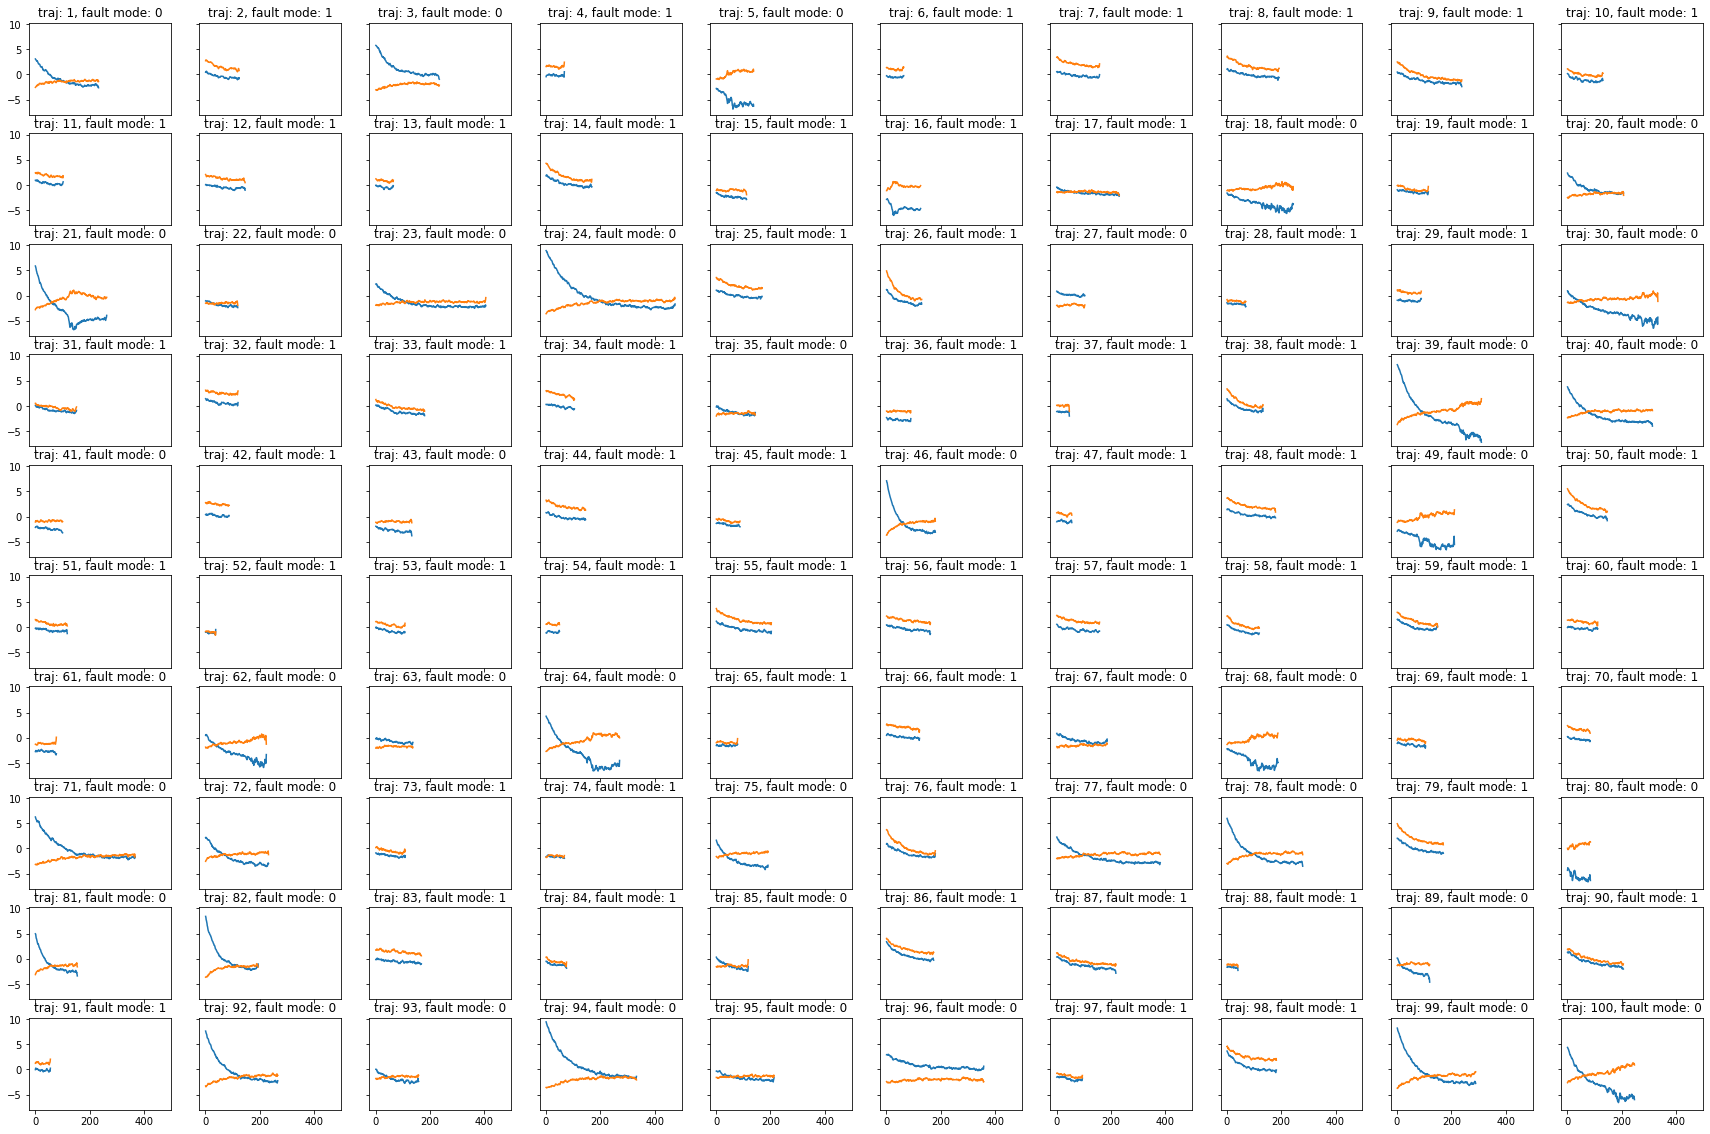

In [46]:
dataPD = test_dataPD
cats = meta['lin_test_fault_modes']
nrows=10
ncols=10
plotRows=1
fig, ax = pp.subplots(figsize=(30,20),nrows=nrows*plotRows, ncols=ncols, sharex=True, sharey=True,)
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx*plotRows
        col=traj_idx
        data_idx = ncols*traj_jdx+traj_idx+1
        #ax[row,col].plot(dataPD.loc[data_idx,'op1']*1000)
        #ax[row,col].plot(dataPD.loc[data_idx,'op2']*5000,alpha=0.4)
        #ax[row,col].axhline(y=0)
        # get mask
        for pc in progSig:
            trace=dataPD.loc[data_idx,pc]
            ax[row,col].plot(trace)

            
            pc_idx+=1
        ax[row,col].set_title('traj: %d, fault mode: %d' % (data_idx,cats[data_idx]))

            

The fault modes are identified correctly in most cases also in the test data set. Although I am not sure about the result in trajectory 4.

# the RUL estimation

Try to fit the exponential model for the test data to estimate the RUL. 

The test dataset will be grouped by the fault mode.

In [47]:
# data
fm=0
fm_traj = meta['lin_test_fault_modes'][meta['lin_test_fault_modes']==fm].index
dataPD = test_dataPD.loc[fm_traj,:]
maskSignal = 'pc4'
progSig = ['pc1',] # prognostic signals    

# data structure for the fit result
pcolumns = [ 'k1', 'y1', 'RUL' ,'k1std', 'y1std', 'RUL1std'] # parameter columns

# initial fit parameters for the fitting function

s = meta['exp_train_fit'][meta['exp_train_fit']['fault mode']==fm].describe() # statistics of the columns
pc_t0 = (s['A1']+s['y1']).describe()['mean']
RUL_min = 0
RUL_max = 6/s.loc['max','k1']

mins = s.loc['min',['k1','y1']].values
mins = np.hstack([mins,np.array([RUL_min])]) 
maxs = s.loc['max',['k1','y1']].values
maxs = np.hstack([maxs,np.array([RUL_max])]) 

p0 = s.loc['mean',['k1','y1']].values
p0 = np.hstack([p0,np.array([0])]) 
                         
base_span = 30
#p0 = []
# get the boundaries
bounds=(-np.inf,np.inf)
#bounds=(mins,maxs)

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20

In [48]:


# Function to calculate the exponential with rate constant k
def exponential_RUL(pc_t0, x, k, y, RUL):
    # the x means the reverse time, breakdown is expected at x-RUL = 0
    # pc_t0 is calculated mean value of the terminal PC signal
    A=pc_t0-y
    return (A*np.exp(-k*(x+RUL))  + y) 
                         
expmodel_RUL = model(dataPD, progSig,maskSignal,
                     lambda x, k, y, RUL : exponential_RUL(pc_t0,x, k, y, RUL),
                     p0,bounds,base_span,pcolumns)

fit_expDF = expmodel_RUL.fit()

In [49]:
fit_expDF.head()

,k1,y1,RUL,k1std,y1std,RUL1std
unit,,,,,,
1,0.016383,-2.419681,81.508475,0.000292,0.025250,1.653031
3,0.020771,-0.180737,53.288952,0.000353,0.022194,1.152398
5,0.030994,-4.857558,86.139509,0.017271,0.209052,51.351023
18,0.012240,-4.205351,179.131424,0.001680,0.191471,20.448228
20,0.019495,-1.767749,81.777975,0.000542,0.028091,2.548053


In [50]:
meta['exp_test_fit_by_fault']=[]
meta['exp_test_fit_by_fault'].append(fit_expDF)

### case of the Fan deterioration fault mode

In [51]:
# data
fm=1 # fault mode
fm_traj = meta['lin_test_fault_modes'][meta['lin_test_fault_modes']==fm].index
dataPD = test_dataPD.loc[fm_traj,:]
maskSignal = 'pc4'
progSig = ['pc2',] # prognostic signals    

# data structure for the fit result
pcolumns = [ 'k2', 'y2', 'RUL' ,'k2std', 'y2std', 'RUL1std'] # parameter columns

# initial fit parameters for the fitting function

s = meta['exp_train_fit'][meta['exp_train_fit']['fault mode']==fm].describe() # statistics of the columns
pc_t0 = (s['A2']+s['y2']).describe()['mean']
RUL_min = 0
RUL_max = 6/s.loc['max','k2']

mins = s.loc['min',['k2','y2']].values
mins = np.hstack([mins,np.array([RUL_min])]) 
maxs = s.loc['max',['k2','y2']].values
maxs = np.hstack([maxs,np.array([RUL_max])]) 

p0 = s.loc['mean',['k2','y2']].values
p0 = np.hstack([p0,np.array([100])]) 
                         
base_span = 30
#p0 = []
# get the boundaries
bounds=(mins,maxs)

# mask parameters
# mask parameters:
window_size = 20
rmsdev_thrshld = 0.3
minMaskLen = 20

In [52]:


# Function to calculate the exponential with rate constant k
def exponential_RUL(pc_t0, x, k, y, RUL):
    # the x means the reverse time, breakdown is expected at x-RUL = 0
    # pc_t0 is calculated mean value of the terminal PC signal
    A=pc_t0-y
    return (A*np.exp(-k*(x+RUL))  + y) 
                         
expmodel_RUL = model(dataPD, progSig,maskSignal,
                     lambda x, k, y, RUL : exponential_RUL(pc_t0,x, k, y, RUL),
                     p0,bounds,base_span,pcolumns)

fit_expDF = expmodel_RUL.fit()


In [53]:
meta['exp_test_fit_by_fault'].append(fit_expDF)


In [54]:
meta['exp_test_fit']= pd.DataFrame(index=testData[meta['idx']].index.get_level_values(level=0).unique(),
                                  columns=['RUL','RULstd'],
                                  dtype=np.float)
for fit_expDF in meta['exp_test_fit_by_fault']:
    meta['exp_test_fit'].loc[fit_expDF.index,:] = fit_expDF.loc[:,['RUL','RUL1std']].values

### checking whether we fitted RULS well

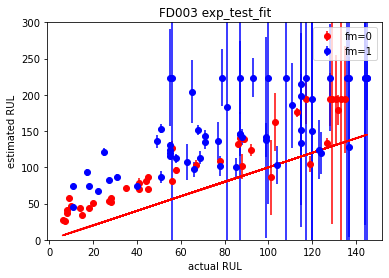

In [55]:
ax=pp.axes()
fm=0
pp.errorbar(RUL[meta['idx']].loc[meta['exp_test_fit_by_fault'][fm].index-1].values,
            meta['exp_test_fit_by_fault'][fm].loc[:,'RUL'].values,
            yerr=meta['exp_test_fit_by_fault'][fm].loc[:,'RUL1std'].values,
            #yerr=np.zeros(len(meta['exp_test_fit'].loc[:,'RULstd'].values)),
            xerr=None,
            fmt='ro',label='fm=%d'%fm)
fm=1
pp.errorbar(RUL[meta['idx']].loc[meta['exp_test_fit_by_fault'][fm].index-1].values,
            meta['exp_test_fit_by_fault'][fm].loc[:,'RUL'].values,
            yerr=meta['exp_test_fit_by_fault'][fm].loc[:,'RUL1std'].values,
            #yerr=np.zeros(len(meta['exp_test_fit'].loc[:,'RULstd'].values)),
            xerr=None,
            fmt='bo',label='fm=%d'%fm)
pp.legend()
pp.xlabel('actual RUL')
pp.ylabel('estimated RUL')
pp.title(meta['Data Set Name']+ ' exp_test_fit')
ax.set_ylim([0,300])
ax.plot(RUL[meta['idx']].values,RUL[meta['idx']].values,'r-')

pp.savefig('models/exponential_test_fit_FD003.png')

 The results of the prediction using the exponetial are not convincing.
 
* Up to about 55 cycles the fit error is acceptable, but in higher range the exponential fit alone cannot predict the RUL with reasonable precision. 
* the estimated RUL is about 1.5-2 higher than what is the ground truth value.
 
 
 We need to implement some limitation for the maximal reasonable RUL. The possibilities include:
 
* set the lifetime limit as maximal time, when the sensor reading starts to deviate from the baseline more than 10% until the failure.
    * good starting point are the k values found for the training dataset.
    * I have set 6/max(k) as a limit of RUL, and this cropped the predictions at level of about 220 cycles. This restriction help, but it is not ideal.
    
* try to infer the RUL characteristics from the op1 and op2 characteristics. But so far the parameters do not show significant correlation with the k value...


In [56]:
truths = RUL[meta['idx']].iloc[:,].values[:,0]
predicts = meta['exp_test_fit'].loc[:,'RUL'].values
difference = predicts-truths
sum_of_devs = np.sum(np.power(difference,2))
RMSE = np.sqrt(sum_of_devs/predicts.shape[0])
sum_of_squares = np.sum(np.power(truths,2))
R2 = 1-sum_of_devs/sum_of_squares
model_id='exponential'
print ('dataset: %s, model: %s, RMSE = %.1f cycles, Rsquared = %.3f' % (meta['Data Set Name'],model_id,RMSE,R2))

dataset: FD003, model: exponential, RMSE = 66.9 cycles, Rsquared = 0.394


In [58]:
meta['exp_test_fit'].to_csv('models/exponential_test_fit.csv')